---

## LSTM multicouches


---

## Avantages
1. **Capture des tendances :** Les LSTM mémorisent les variations saisonnières et les tendances à long terme dans les données de ventes.
2. **Gestion des dépendances temporelles :** Adaptés pour modéliser les relations entre les ventes passées et futures.
3. **Précision :** Gèrent les séries temporelles complexes, comme les variations dues à des événements spécifiques (soldes, fêtes).
4. **Flexibilité :** Fonctionnent avec des données multivariées (e.g., météo, promotions) pour des prévisions plus précises.


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from useful_functions import *
file_path = "./results.json"

In [4]:
# --Tables--
series_train = pd.read_csv("series_train.csv",sep=';')
series_test = pd.read_csv("series_test.csv",sep=';')

In [5]:
dataset_train = series_train['sales'].values.reshape(-1, 1)
dataset_test = series_test['sales'].values.reshape(-1, 1)


scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.transform(dataset_test)

Pour les réseaux de neurones, il est essentiel de normaliser les données avec `MinMaxScaler` afin de :
- Accélérer la convergence de l'entraînement (pour adam).
- Éviter que des caractéristiques avec des plages de valeurs très différentes n'influencent de manière disproportionnée les poids du modèle.

La mise à l'échelle Min-Max redimensionne les données dans une plage spécifiée, généralement entre 0 et 1, en utilisant la formule suivante :

$$
x_{\text{scaled}} = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
$$

où :
- $x$ : la valeur initiale d'une caractéristique.
- $x_{\min}$ et $x_{\max}$ : les valeurs minimale et maximale de la caractéristique.
- $x_{\text{scaled}}$ : la valeur normalisée, comprise entre 0 et 1.

In [6]:
lag_size = 7 #h=0, on a pas de retard sur les données, 7 trouvé dans le module Sarimax avec analsye acf pacf
X_train, y_train, X_test, y_test = [], [], [], []

# --training--
for i in range(lag_size, len(scaled_train)):
    X_train.append(scaled_train[i - lag_size:i, 0])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# --testing--
for i in range(lag_size, len(scaled_test)):
    X_test.append(scaled_test[i - lag_size:i, 0])
    y_test.append(scaled_test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

 ### Explication du reshape dans les séries temporelles

Lorsqu'on utilise des modèles séquentiels comme les LSTM ou GRU, les données doivent être formatées correctement. Les modèles attendent en entré les données sous la forme suivante :

$$
(n_{\text{samples}}, \text{timesteps}, \text{features})
$$

##### Reshape de `X_test`, $(n_{\text{samples}}, \text{lag\_size})$ --> $(n_{\text{samples}}, \text{timesteps}, \text{features})$

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [8]:
# initializing the LSTM
regressorLSTM = Sequential()
 
#Adding LSTM layers
regressorLSTM.add(LSTM(units=256,#bcp de neuronne car données pas lineaire, un peu compliqué
                       activation = 'tanh' ,#pour données symetrique c'est bien
                       return_sequences = True, 
                       input_shape = (X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(units=128,#bcp de neuronne car données pas lineaire, un peu compliqué
                       activation = 'tanh' ,#pour données symetrique c'est bien
                       return_sequences = True, 
                       input_shape = (X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
regressorLSTM.add(LSTM(units=64,#bcp de neuronne car données pas lineaire, un peu compliqué
                       activation = 'tanh' ,#pour données symetrique c'est bien
                       return_sequences = False, 
                       input_shape = (X_train.shape[1],1)))
regressorLSTM.add(Dropout(0.2))
#Adding the output layer
regressorLSTM.add(Dense(50))
regressorLSTM.add(Dense(1))
 
#Compiling the model
regressorLSTM.compile(optimizer = 'adam',
                      loss = 'mean_squared_error',
                      metrics = ["accuracy"])
 
#Fitting the model
regressorLSTM.fit(X_train,y_train,
              batch_size=32,
              epochs=50,
              validation_split=0.2
              )
regressorLSTM.summary()

C:\Users\ouaha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 2.6556e-04 - loss: 0.0178 - val_accuracy: 0.0000e+00 - val_loss: 0.0158
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.0014 - loss: 0.0053 - val_accuracy: 0.0000e+00 - val_loss: 0.0117
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 9.2136e-04 - loss: 0.0037 - val_accuracy: 0.0000e+00 - val_loss: 0.0115
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 8.2960e-05 - loss: 0.0044 - val_accuracy: 0.0000e+00 - val_loss: 0.0093
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.0023 - loss: 0.0038 - val_accuracy: 0.0000e+00 - val_loss: 0.0081
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 3.6943e-04 - loss: 0.0047 - val_accuracy: 0.0000e+00 - val_loss: 0.0080
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.0033 - loss: 0.0045 - val_accuracy: 0.0000e+00 - val_loss: 0.0086
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 3.1

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 256)              │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 128)              │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           3,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,542,065 (5.88 MB)

 Trainable params: 514,021 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,028,044 (3.92 MB)

Testing

In [9]:
test_loss = regressorLSTM.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

train_predictions = regressorLSTM.predict(X_train)
test_predictions = regressorLSTM.predict(X_test)

# Inversion de la normalisation
train_predictions_inversed = scaler.inverse_transform(train_predictions)
test_predictions_inversed = scaler.inverse_transform(test_predictions)


series_train['train_Forecast_LSTM'] = np.nan
series_train.loc[lag_size:, 'train_Forecast_LSTM'] = train_predictions_inversed.flatten()

series_test['test_Forecast_LSTM'] = np.nan
series_test.loc[lag_size:, 'test_Forecast_LSTM'] = test_predictions_inversed.flatten()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0128
Test Loss: [0.014679900370538235, 0.0]
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


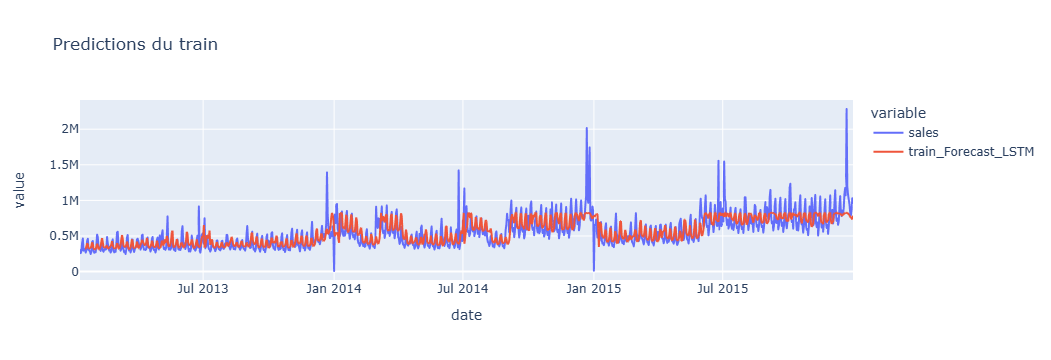

In [13]:
fig = px.line(series_train, x='date', y=['sales', 'train_Forecast_LSTM'],title="Predictions du train")
fig.show()

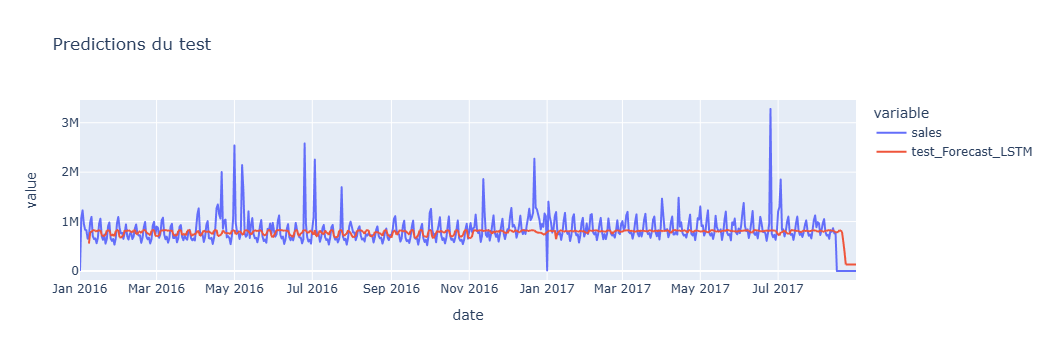

In [14]:
fig = px.line(series_test, x='date', y=['sales', 'test_Forecast_LSTM'],title="Predictions du test")
fig.show()

In [15]:
nrmse, mape, mae,r2 = calculate_metrics(series_test.loc[lag_size:, 'sales'], series_test.loc[lag_size:, 'test_Forecast_LSTM'])
print(nrmse)
print(mape)
print(mae)
print(r2)
        

0.08409679892893983
4.643845084821235e+19
165207.2585018719
0.13227834862867394


```python
save_model_results(
    file_path=file_path,
    model_name="LSTM_multicouches",
    params="3couches lstm 3 dropout" ,
    nrmse=nrmse,
    mape=mape,
    mae=mae,
    r2=r2
)
```

In [16]:
series_train.to_csv("series_train.csv", index=False, header=True, sep=';')
series_test.to_csv("series_test.csv", index=False, header=True, sep=';')